In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import nltk
import re
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings

pd.set_option('display.max_columns', 100)

warnings.filterwarnings('ignore')

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
STOP_WORDS = nltk.corpus.stopwords.words()

dpath = "../data/multidimensional.csv"
df = pd.read_csv(dpath)
df.head()

[nltk_data] Downloading package stopwords to /home/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jiqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,unit_id,tries_amount,questionnaire_amount,dimensions_amount,document_amount,current_try,q_0_age_question,q_0_age_answer,q_0_age_value,q_0_school_question,q_0_school_answer,q_0_school_value,q_0_taxes_question,q_0_taxes_answer,q_0_taxes_value,q_0_political_views_question,q_0_political_views_answer,q_0_political_views_value,q_0_consideration_question,q_0_consideration_answer,q_0_consideration_value,q_0_southern_border_question,q_0_southern_border_answer,q_0_southern_border_value,q_0_environment_question,q_0_environment_answer,q_0_environment_value,q_0_time_elapsed,q_0_accesses,q_1_farmers_question,q_1_farmers_answer,q_1_farmers_value,q_1_time_elapsed,q_1_accesses,q_2_marks_question,q_2_marks_answer,q_2_marks_value,q_2_time_elapsed,q_2_accesses,q_3_athletics_question,q_3_athletics_answer,q_3_athletics_value,q_3_time_elapsed,q_3_accesses,doc_index,doc_name,doc_statement,doc_claimant,doc_date,doc_originatedFrom,doc_ground_truth_value,doc_ground_truth_abc_label,doc_ground_truth_abc_verdict,doc_ground_truth_politifact_label,doc_source,doc_overall-truthfulness_value,doc_overall-truthfulness_label,doc_overall-truthfulness_justification,doc_overall-truthfulness_url,doc_confidence_value,doc_confidence_label,doc_confidence_justification,doc_confidence_url,doc_correctness_value,doc_correctness_label,doc_correctness_justification,doc_correctness_url,doc_neutrality_value,doc_neutrality_label,doc_neutrality_justification,doc_neutrality_url,doc_comprehensibility_value,doc_comprehensibility_label,doc_comprehensibility_justification,doc_comprehensibility_url,doc_precision_value,doc_precision_label,doc_precision_justification,doc_precision_url,doc_completeness_value,doc_completeness_label,doc_completeness_justification,doc_completeness_url,doc_speaker's-trustworthiness_value,doc_speaker's-trustworthiness_label,doc_speaker's-trustworthiness_justification,doc_speaker's-trustworthiness_url,doc_informativeness_value,doc_informativeness_label,doc_informativeness_justification,doc_informativeness_url,doc_accesses,doc_time_elapsed
0,unit_1,10,4,9,11,1,What is your age range?,26-35,2.0,What is the highest level of school you have c...,"Some college (some community college, associat...",2.0,Last year what was your total family income fr...,"30,000 to less than 40,000",3.0,"In general, would you describe your political ...",Very liberal,4.0,"In politics today, do you consider yourself a",Independent,2.0,Should the U.S. build a wall along the souther...,Disagree,1.0,Should the government increase environmental r...,Agree,0.0,38.6,1,If three farmers can plant three trees in thre...,NaN,1.0,17.98,1,Sean received both the 5th highest and the 5th...,NaN,9.0,23.91,1,"In an athletics team, females are four times m...",NaN,4.0,274.19,1,0.0,Liberal_In_Between_doc1,What the states do is a matter for the states ...,Tony Abbott,2013.0,NaN,3.0,in-between,lawyer's picnic,NaN,abc,1.0,agree,NaN,https://www.thenewamerican.com/usnews/constitu...,-1.0,disagree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,1.0,agree,NaN,NaN,-1.0,disagree,NaN,NaN,0.0,neither-agree-nor-disagree,NaN,NaN,1.0,agree,NaN,NaN,1.0,175.61
1,unit_1,10,4,9,11,1,What is your age range?,26-35,2.0,What is the highest level of school you have c...,"Some college (some community college, associat...",2.0,Last year what was your total family income fr...,"30,000 to less than 40,000",3.0,"In general, would you describe your political ...",Very liberal,4.0,"In politics today, do you consider yourself a",Independent,2.0,Should the U.S. build a wall along the souther...,Disagree,1.0,Should the government increase environmental r...,Agree,0.0,38.6,1,If three farmers can plant three trees in thre...,NaN,1.0,17.98,1,Sean received both the 5th highest and the 5th...,NaN,9.0,23.91,1,"In an athletics team, females are four times m...",NaN,4.0,274.19,1,1.0,Labor_Negative_doc3,Mr Abbott seems to be suffering from just a li...,Kevin Rudd,2013.0,NaN,4.0,negative,wrong,NaN,abc,2.0,completely-agree,NaN,https://

In [2]:
# compute CRT scores
q1_value = df["q_1_farmers_value"]
q1_score = (q1_value == 3.0).astype("int")
df["q_1_farmers_score"] = q1_score

q2_value = df["q_2_marks_value"]
q2_score = (q2_value == 9.0).astype("int")
df["q_2_marks_score"] = q2_score

q3_value = df["q_3_athletics_value"]
q3_score = (q3_value == 16.0).astype("int")
df["q_3_athletics_score"] = q3_score

df["overall_crt_score"] = df["q_1_farmers_score"] + df["q_2_marks_score"] + df["q_3_athletics_score"]

# compute exact match
exact_match = df.loc[df["doc_ground_truth_value"] == df["doc_overall-truthfulness_value"] + 2]

In [3]:
metadata = exact_match[[
    "q_0_age_value", 
    "q_0_school_value", 
    "q_0_taxes_value", 
    "q_0_political_views_value", 
    "q_0_consideration_value", 
    "q_0_southern_border_value", 
    "q_0_environment_value", 
    "q_1_farmers_score", 
    "q_2_marks_score", 
    "q_3_athletics_score", 
]]
metadata.reset_index(drop=True, inplace=True)
metadata.index

RangeIndex(start=0, stop=1081, step=1)

In [4]:
# statements tokenization
def clean_text(t):
    text = re.sub("([^\s\w]|_)+", "", t)
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
    text = text.lower()
    text = text.split(" ")

    for word in list(text):
        if word in STOP_WORDS or len(word) < 2:
            text.remove(word)
    
    text = map(WordNetLemmatizer().lemmatize, text)

    return list(text)

corpus = exact_match["doc_statement"]
corpus = corpus.dropna(how="any")
corpus = corpus.apply(clean_text)

# word embedding
model = word2vec.Word2Vec(corpus, vector_size=50, window=20, workers=4, min_count=1)

In [5]:
# statement embedding as bag of word embedding
corpus_matrix = []
for i, s in corpus.iteritems():
    s_matrix = [model.wv[w] for w in s]
    s_vector = [sum(i) for i in zip(*s_matrix)]
    corpus_matrix.append(s_vector)

In [67]:
# merge metadata with statement embedding together
corpus_df = pd.DataFrame(data=corpus_matrix, 
columns=["statement_d%d" % i for i in range(50)])
metadata.reset_index(drop=True, inplace=True)
y = exact_match["doc_ground_truth_value"]
y.reset_index(drop=True, inplace=True)
corpus_df = (corpus_df - corpus_df.min()) / (corpus_df.max() - corpus_df.min())
metadata = (metadata - metadata.min()) / (metadata.max() - metadata.min())
X = pd.concat([metadata, corpus_df], axis=1)

In [68]:
# evaluate the model
kfold = KFold(n_splits=4)
xgb_model = xgb.XGBClassifier(n_estimators=100, objective="multi:softprob", eval_metric="mlogloss", random_state=23)

results_metadata = cross_val_score(xgb_model, metadata, y, cv=kfold)
results_corpus = cross_val_score(xgb_model, corpus_df, y, cv=kfold)
results_joint = cross_val_score(xgb_model, X, y, cv=kfold)

print("Accuracy metadata only: %.2f%% (%.2f%%)" % (results_metadata.mean() * 100, results_metadata.std() * 100))
print("Accuracy corpus only: %.2f%% (%.2f%%)" % (results_corpus.mean() * 100, results_corpus.std() * 100))
print("Accuracy joint: %.2f%% (%.2f%%)" % (results_joint.mean() * 100, results_joint.std() * 100))

Accuracy metadata only: 27.94% (2.28%)
Accuracy corpus only: 40.70% (0.43%)
Accuracy joint: 36.91% (1.43%)


Text(0.5, 0, 'XGBoost Built-in Feature Importance')

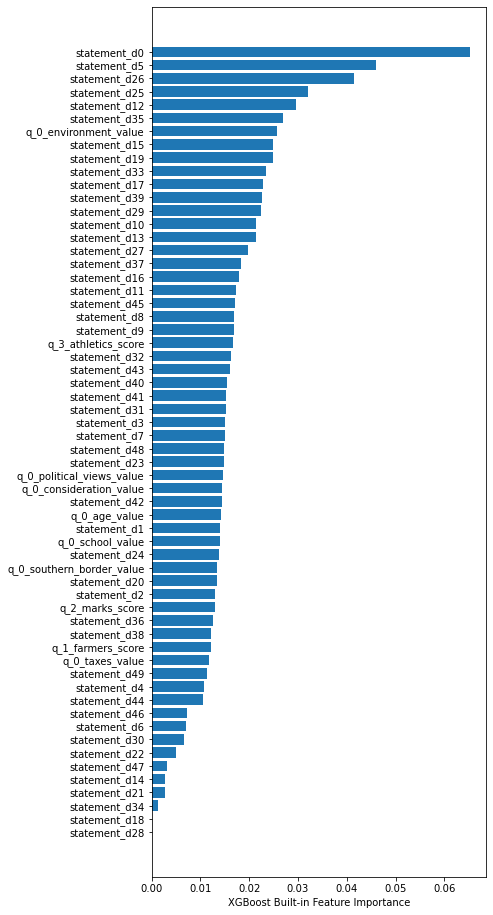

In [69]:
# xgboost built-in feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)
xgb_model = xgb.XGBClassifier(n_estimators=100, objective="multi:softprob",eval_metric="merror", random_state=23)
xgb_model.fit(X_train, y_train)
sort_index = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(6, 16))
plt.barh(X_train.columns[sort_index], xgb_model.feature_importances_[sort_index])
plt.xlabel("XGBoost Built-in Feature Importance")

Text(0.5, 0, 'Permutation Importance')

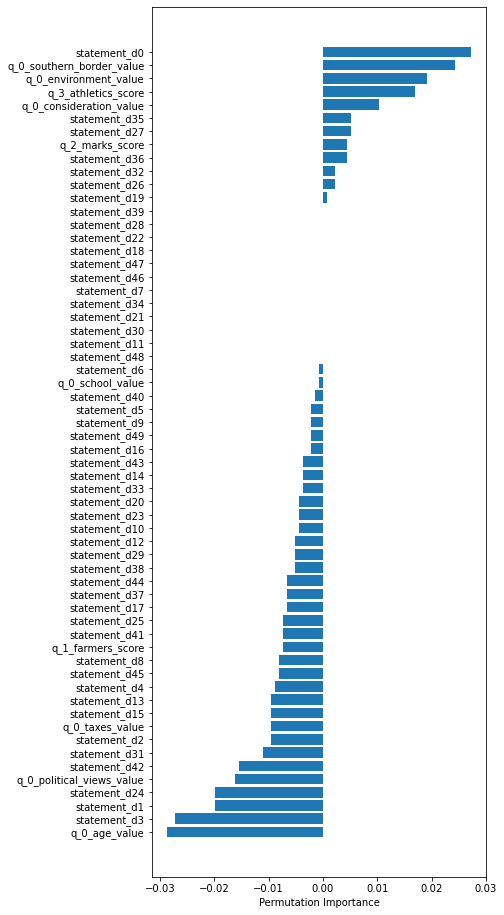

In [63]:
perm_importance = permutation_importance(xgb_model, X_test, y_test, random_state=23)
sort_index = perm_importance.importances_mean.argsort()
plt.figure(figsize=(6, 16))
plt.barh(X_train.columns[sort_index], perm_importance.importances_mean[sort_index])
plt.xlabel("Permutation Importance")

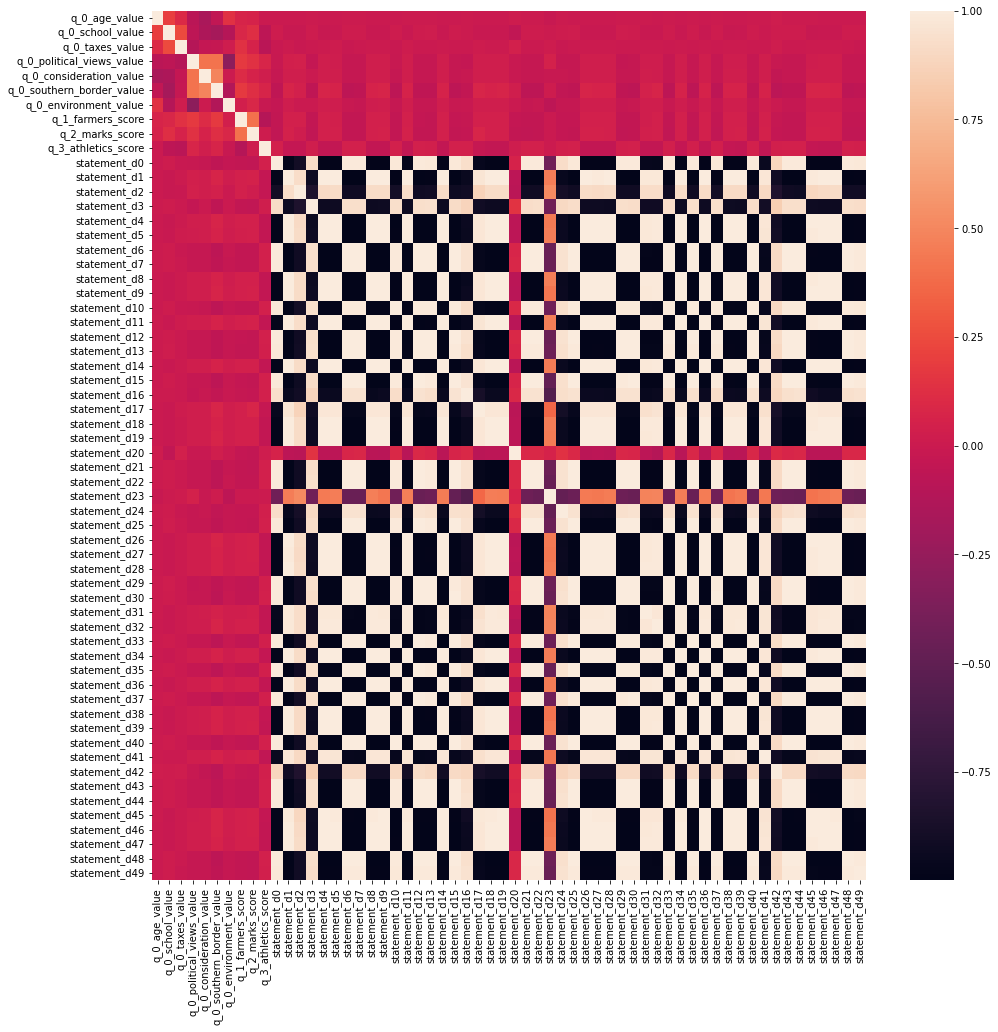

In [64]:
# correlation matrix of the training set
plt.figure(figsize=(16, 16))
sns.heatmap(X_train.corr(), fmt=".2f")
plt.show()